# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
# Imagen para estilo
!wget https://www.savinarte.com/wp-content/uploads/2018/11/Kandinsky_001.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/0/04/Labrador_Retriever_%281210559%29.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
La sintaxis del comando no es correcta.


In [2]:
import tensorflow._api.v2.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [7]:
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
from pathlib import Path

In [4]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/Labrador_Retriever_(1210559).jpg")
style_reference_image_path = Path("/content/Kandinsky_001.jpg")
result_prefix = Path("/content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta: 

Los parametros "total_variation_weight" (Peso asociado con la pérdida de variación total), "style_weight" (Peso asignado a la perdida del estilo) y  "content_weight" (Peso asociado a la pérdida de contenido) son pesos que se usan para equilibrar los diferentes componentes de la función de pérdida total en el proceso de la estilización basada en el metodo descripto. Estos pesos determinan la importancia relativa de cada término en la función de pérdida.

In [5]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [6]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta: La función preprocess_image esta diseñada para cargar y preprocesar una imagen para que pueda ser utilizada por la red VGG19. Las ultimas dos lineas antes del return son criticas para garantizar que la imagen esté en el formato correcto para ser pasada a la red VGG19. La primera asegura que la imagen se presente en un ormato de batch, y la segunda realiza el preprocesamiento especifico requerido por la VGG19.

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta: La función deprocess_image realiza la operación inversa a la función anterior, ya que preprocess_image prepara una imagen para ser procesada por la red VGG19, deprocess_image transforma la imagen procesada por la red a un formato visualizable y comprensible. En resumen, redimensiona la imagen a su tamaño original, quita la media que fue aplicada durante el preprocesamiento, convierte la imagen de BGR a RGB y se asegura que los pixeles esten en el rango [0,255] y los convierte en enteros. Por lo tanto la relación que tienen ambas celdas es que, despues de procesar la imagen con VGG19, se usara la función deprocess para convertir la salida de la red nuevamente en una imagen visualizable en su formato original.

In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])




80142336/80134624 [==============================] - 3s 0us/step






Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa? 

La matriz de Gram es un recurso matematico que captura la correlación entre los canales de una caracteristica en redes neuronales convolucionales. En el contexto del paper, la matriz se utiliza para representar el estilo de una imagen es decir, las pautas de respuesta conjunta de los mapas de características de la capa.

- ¿Por qué se permutan las dimensiones de x?

 Se permuta las dimensiones de X para preparar el tensor de manera que pueda ser compactado adecuadamente y, posteriormente, utilizado para calcular la matriz de Gram. El objetivo es transformar el tensor original en una forma donde los canales estén en las filas y las características de espacio (altura * ancho) estén en las columnas, haciendo posible el cálculo de las correlaciones entre canales con un producto punto simple.

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

1- La función style_loss mide cuánto difiere el estilo de una imagen generada (combinación) de una imagen de estilo de referencia. La "diferencia de estilo" se cuantifica a través de las diferencias entre las matrices de Gram de las dos imágenes, que capturan las correlaciones entre los canales de características en una capa específica de una CNN.

2- La función content_loss mide cuánto difiere el contenido de una imagen generada (combinación) de una imagen base de referencia. Esta "diferencia de contenido" se cuantifica mediante la distancia cuadrada entre las características de las dos imágenes. En el contexto de la transferencia de estilo, la "imagen base" es la imagen original a la que queremos aplicar el estilo, y esta función ayuda a garantizar que la imagen resultante aún retenga el contenido de la imagen original mientras se le aplica un nuevo estilo.

3- La función total_variation_loss mide la variación o la discontinuidad en la imagen, tanto vertical como horizontalmente. Esta pérdida se utiliza para promover la suavidad y coherencia en la imagen generada, reduciendo así el ruido y los artefactos. Es especialmente útil en la transferencia de estilo para garantizar que la imagen resultante sea visualmente agradable y no contenga visuales no deseados.

In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta: 

Las tres celdas presentadas están diseñadas para interactuar con la función de optimización fmin_l_bfgs_b de SciPy. Esta función optimiza una función objetivo dada, en este caso, la función de pérdida compuesta que combina la pérdida de contenido, la pérdida de estilo y la pérdida de variación total.

Función eval_loss_and_grads:

Ajusta la forma del tensor x a la dimensión esperada.
Usa f_outputs([x]) para obtener la pérdida y los gradientes. En este caso, f_outputs hace referencia a una función Keras que devuelve tanto el valor de la pérdida como sus gradientes cuando se le da una imagen, en resumen la función devuelve la pérdida y sus gradientes en un formato adecuado para el optimizador.

Clase Evaluator:

Esta clase está diseñada para mejorar el optimizador fmin_l_bfgs_b: necesita llamar a las funciones de pérdida y gradientes por separado, pero calcular estas dos cosas por separado en el contexto de las redes neuronales es ineficiente. La solución es calcular ambos al mismo tiempo y almacenarlos para su uso posterior.
loss y grads son dos métodos que serán llamados por el optimizador.
loss calcula y almacena tanto el valor de pérdida como los gradientes.
grads simplemente devuelve los gradientes previamente calculados.

Función fmin_l_bfgs_b:

Es una función de optimización en el módulo scipy.optimize que realiza la optimización utilizando el algoritmo L-BFGS-B (Limited-memory Broyden-Fletcher-Goldfarb-Shanno with Box constraints). Esta optimización es adecuada para problemas con un gran número de variables y se utiliza aca porque puede manejar eficientemente la optimización de los píxeles de la imagen.

Diferencia con la implementación del paper:

En el paper original, los autores emplearon una técnica de descenso de gradiente para minimizar la función de pérdida. En la implementación que presente, se usa el algoritmo L-BFGS-B, que es una variante mas avanzada del método de descenso de gradiente.

Alternativas:

Se pueden utilizar otros algoritmos de optimización, como Adam o RMSprop. Sin embargo, en la práctica, fmin_l_bfgs_b puede ser mas efectivo para este tipo de tarea. El uso de L-BFGS-B en lugar de un optimizador tradicional como Adam tiende a producir imágenes con menos ruido y más coherentes visualmente en menos iteraciones.


In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [ ]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 13273409000.0
Image saved as /content/output/output_at_iteration_0.png
Iteration 0 completed in 11s
Start of iteration 1
Current loss value: 6347451000.0
Image saved as /content/output/output_at_iteration_1.png
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 4452764000.0
Image saved as /content/output/output_at_iteration_2.png
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 3511758300.0
Image saved as /content/output/output_at_iteration_3.png
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 2822316000.0
Image saved as /content/output/output_at_iteration_4.png
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 2412456400.0
Image saved as /content/output/output_at_iteration_5.png
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 2135097300.0
Image saved as /content/output/output_at_iteration_6.png
Iteration 6 completed in 4s
Start of iteration 7
Curr

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Rta: las nuevas combinaciones aplicadas fueron total_variation_weight = 10, style_weight = 1, content_weight = 0.1. Con estos valores podemos observar que ya que el content_weight es menor en comparación con el style_weight, la imagen generada no se parece mucho a la imagen original. Por otro lado, como el style tampoco es extremadamente alto, la influencia del estilo no es abrumadora. 

Las diferencias detectadas con los pesos originales total_variation_weight = 0.1, style_weight = 10, content_weight = 1, se centran en que en el primer conjunto se puede esperar una imagen donde el estilo domina y hay menos regularidad/coherencia espacial, mientras que en el segundo conjunto de pesos se puede esperar una imagen mas coherente, pero con una presencia mas debil del contenido original y una moderada influencia del estilo. 



# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta: Se adjunta en el mail Carpeta "9. Combinación de nuevas imagenes"

8. se modificaron los pesos, utilizando total_variation_weight = 10, style_weight = 1, content_weight = 0.1 y 100 iteraciones

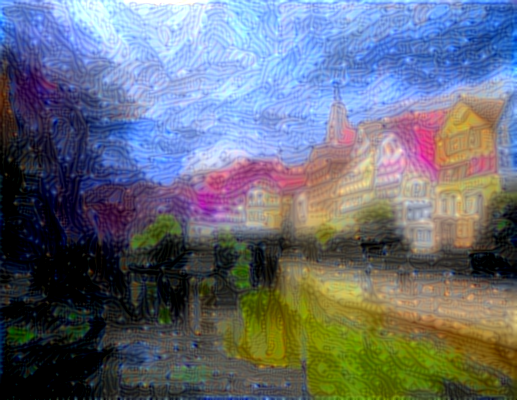

9. se usaron los pesos total_variation_weight = 0.1, style_weight = 10, content_weight = 1 con 100 iteraciones

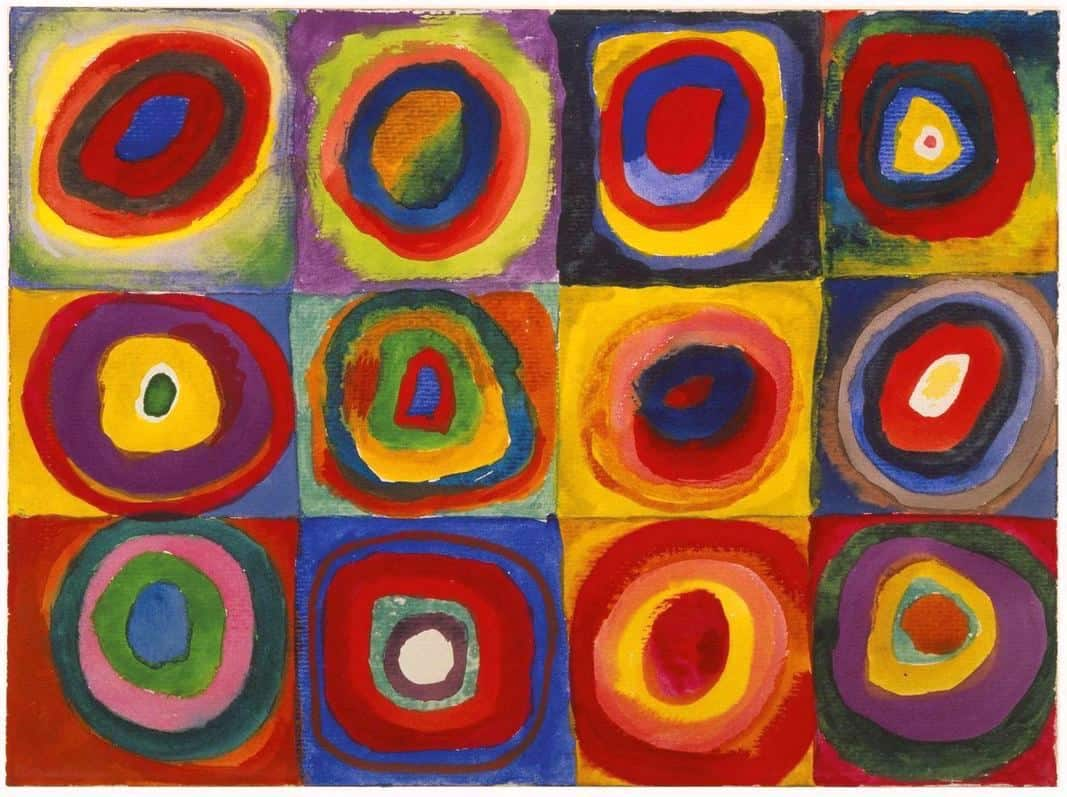 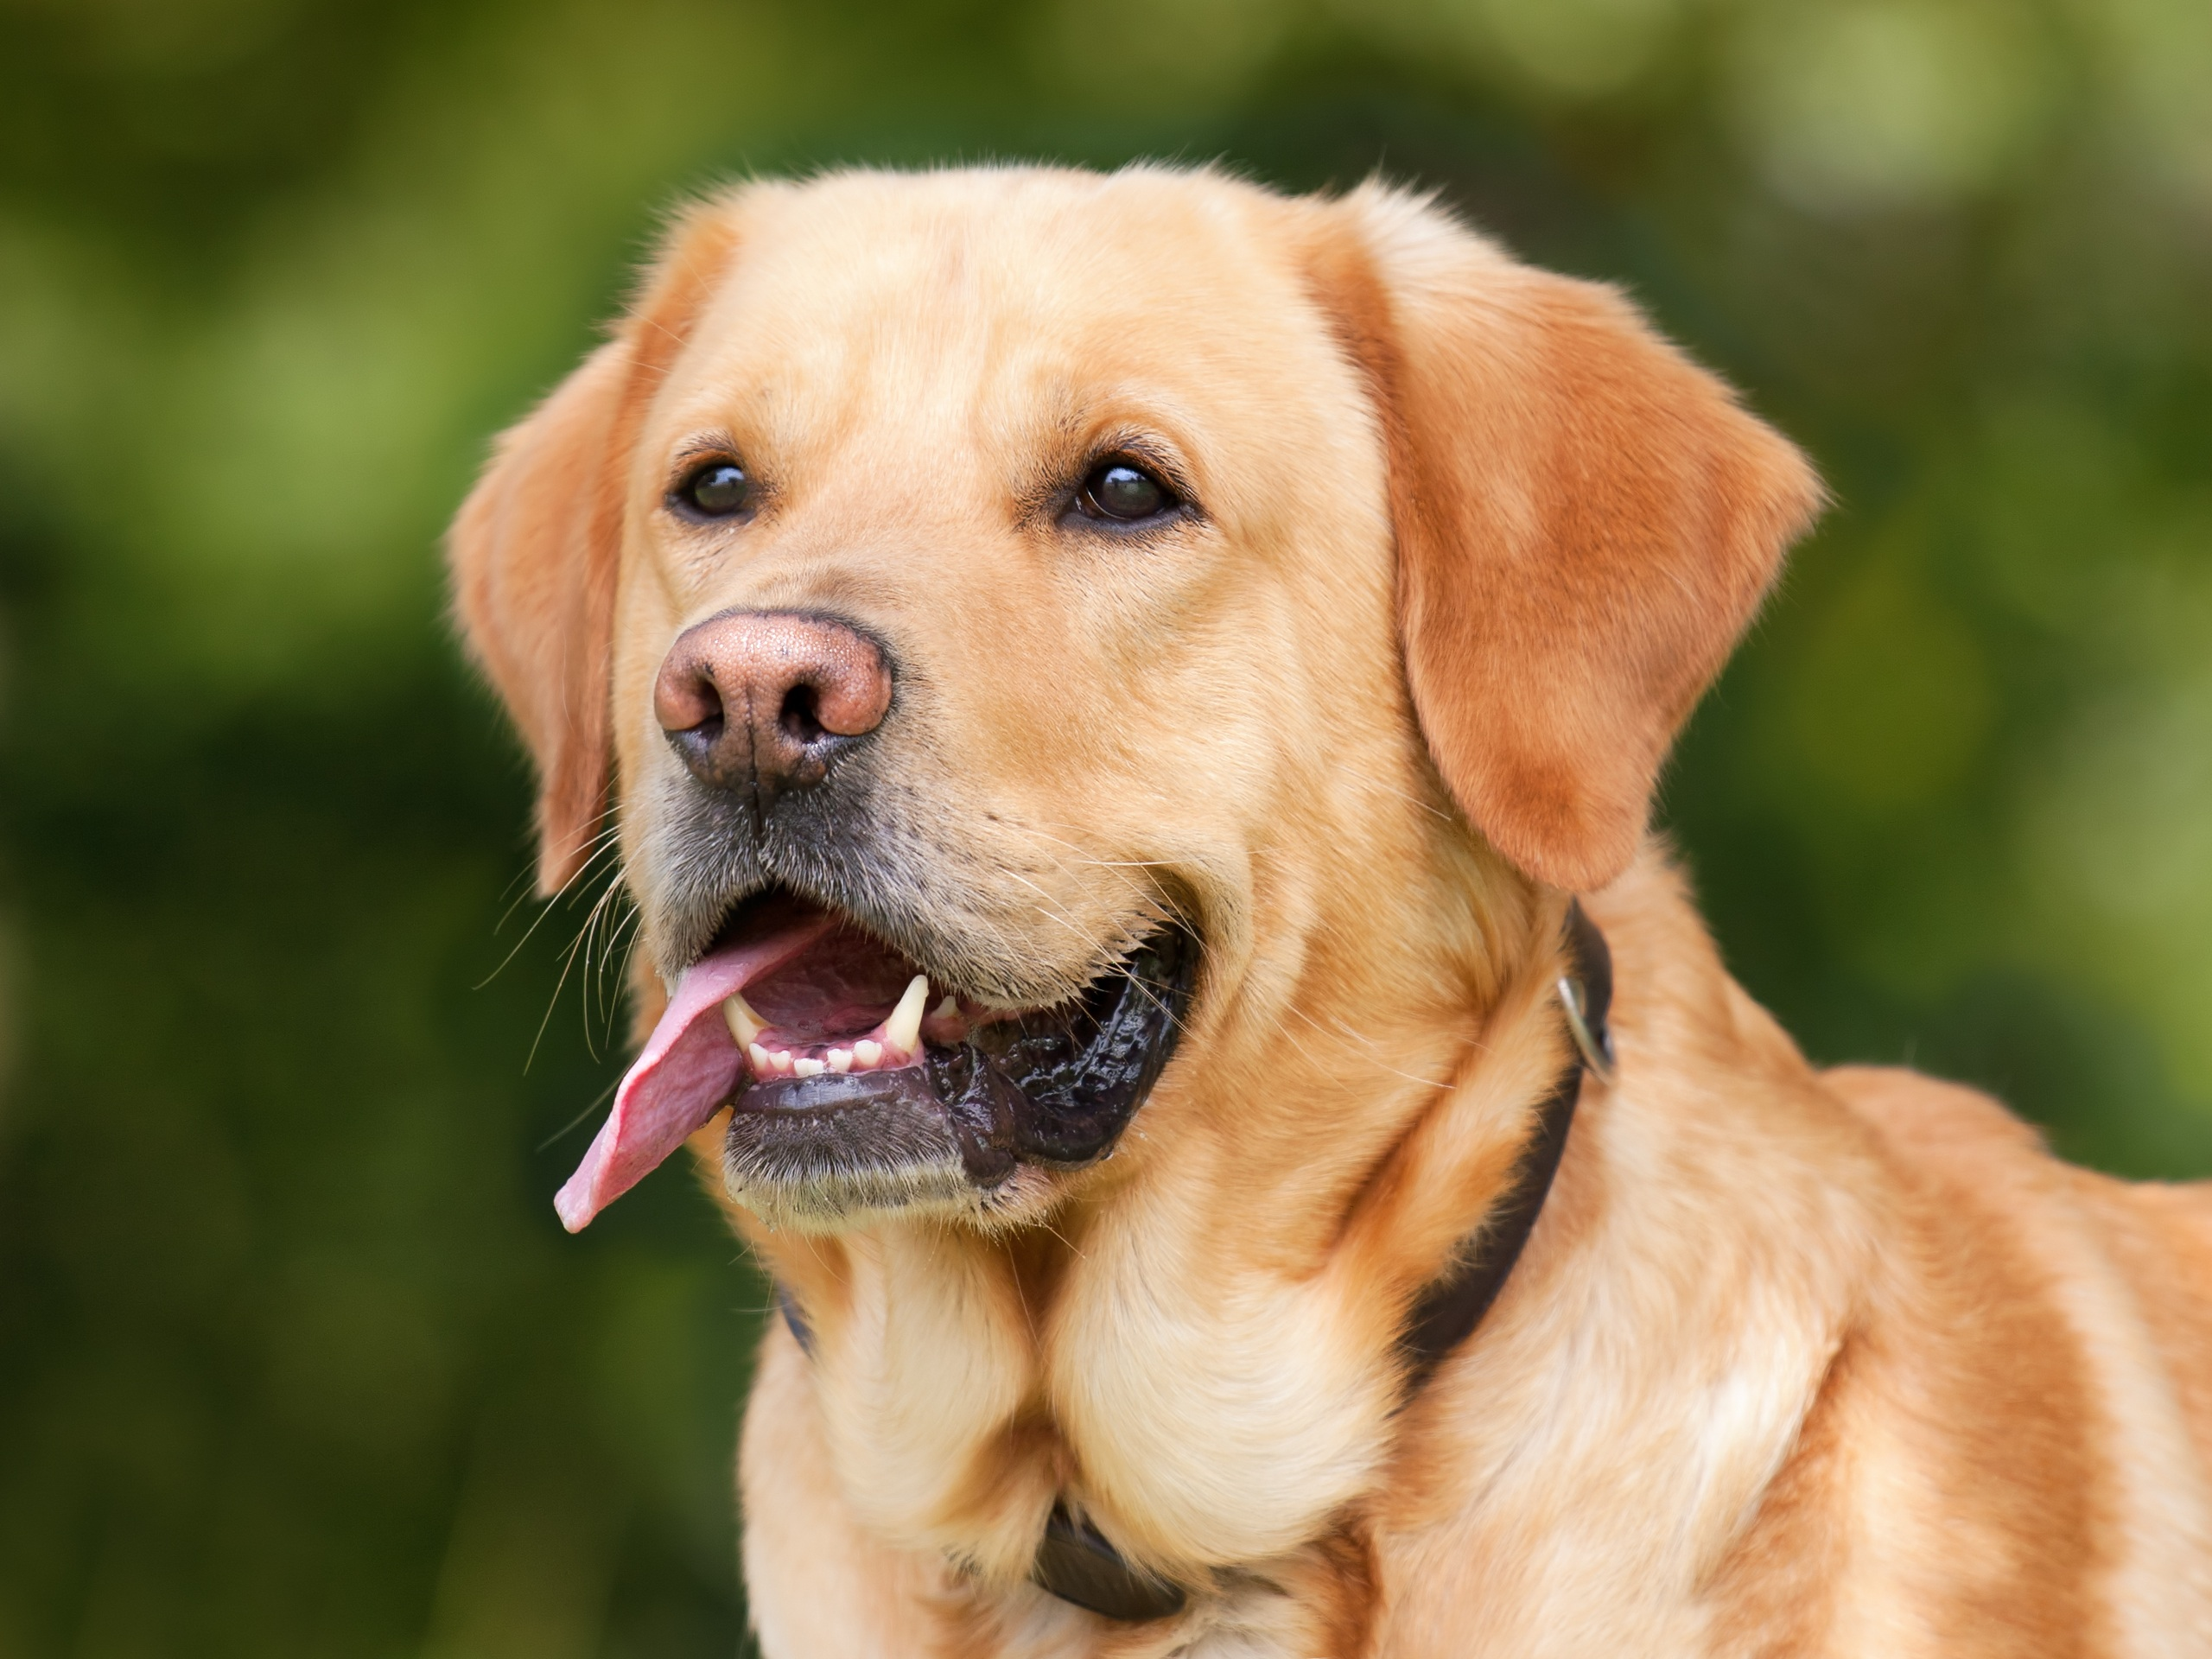

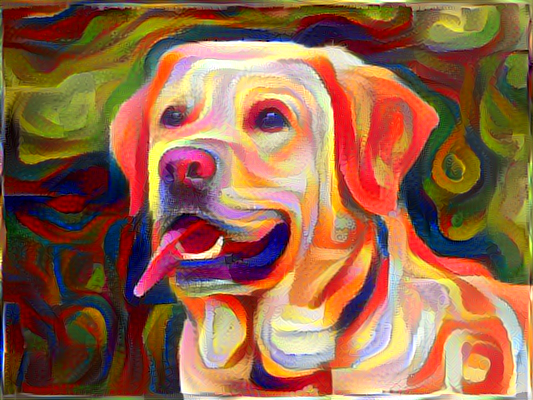